In [1]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 10.7 MB/s eta 0:00:00


In [2]:
import lightgbm as lgb
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np
import pandas as pd
import seaborn as sns
import datetime as dt
from pathlib import Path
import warnings
import os
import random
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from tqdm.notebook import tqdm

import shap

In [3]:
# plt.rcParams['font.family'] = "MS Gothic"
warnings.simplefilter('ignore')

In [4]:
def fix_all_seeds(seed):
    np.random.seed(seed)
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    
fix_all_seeds(0)

In [5]:
# Config
SAVE_SUB = True
SAVE_SUB_DIR = Path("/content/drive/MyDrive/Kaggle/BlueCarbon/proc/sub_20230225")
SUB_FILE_NAME = "val8-1"

# データ読み込み

In [6]:
train = pd.read_pickle("/content/drive/MyDrive/Kaggle/BlueCarbon/proc/train.pkl")
test = pd.read_pickle("/content/drive/MyDrive/Kaggle/BlueCarbon/proc/test.pkl")
sub = pd.read_csv("/content/drive/MyDrive/Kaggle/BlueCarbon/raw/submit_example.csv")

# 特徴抽出後のデータ
umap_basic_train = pd.read_pickle("/content/drive/MyDrive/Kaggle/BlueCarbon/proc/FE_20230417/20230417_umap_basic_train.pkl")
umap_basic_test = pd.read_pickle("/content/drive/MyDrive/Kaggle/BlueCarbon/proc/FE_20230417/20230417_umap_basic_test.pkl")
train_sentinel = pd.read_pickle("/content/drive/MyDrive/Kaggle/BlueCarbon/proc/FE_20230417/20230428_train_sentinel_minmaxDiff.pkl")
test_sentinel = pd.read_pickle("/content/drive/MyDrive/Kaggle/BlueCarbon/proc/FE_20230417/20230428_test_sentinel_minmaxDiff.pkl")
train_landsat_2000to2020 = pd.read_pickle("/content/drive/MyDrive/Kaggle/BlueCarbon/proc/FE_20230417/20230428_train_landsat_2000to2020.pkl")
test_landsat_2000to2020 = pd.read_pickle("/content/drive/MyDrive/Kaggle/BlueCarbon/proc/FE_20230417/20230428_test_landsat_2000to2020.pkl")
train_landsat_minmax = pd.read_pickle("/content/drive/MyDrive/Kaggle/BlueCarbon/proc/FE_20230417/20230428_train_landsat_minmax.pkl")
test_landsat_minmax = pd.read_pickle("/content/drive/MyDrive/Kaggle/BlueCarbon/proc/FE_20230417/20230428_test_landsat_minmax.pkl")

train.head(2)

,lat,lon,area,YMD,year,month,cover,depth_original,cliff_length,aicial_length,...,MIN_NormG_2020,MIN_NormR_2020,MIN_PPR_2020,MIN_PSNDc2_2020,MIN_RDVI_2020,MIN_IF_2020,MIN_SLAVI_2020,MIN_SIPI2_2020,MIN_VARIgreen_2020,mesh20
0,24.989140,125.243164,20.0,20110926,2011.0,9.0,0.050,NaN,0.0,0.000000,...,0.507961,0.287288,-0.278071,-0.808075,-2.341663,2.353039,95.142525,3.728732,-2.405135,3725_10
1,26.996172,127.912025,40.0,2009.7.6-2009.7.28,2009.0,7.0,0.725,NaN,0.0,0.478772,...,0.353645,0.245048,-0.100556,-0.771423,-3.282602,4.672225,174.767501,-0.571513,0.448861,4027_13


In [7]:
sub.head(2)

,0,0.47
0,1,0.68
1,2,0.25


# 前処理

## 対数変換

In [8]:
train[f"log_cover"] = np.log1p(train["cover"])

## 特徴抽出後のデータを結合

In [9]:
print(train.shape)
print(train_landsat_minmax.shape)
print(test.shape)
print(test_landsat_minmax.shape)
train_landsat_minmax.head(2)

(14140, 3465)
(14140, 50)
(4039, 3463)
(4039, 50)


,MINMAX_MVI,MINMAX_Chlred_edge,MINMAX_NLI,MINMAX_IF,MINMAX_GEMI,MINMAX_Chlgreen,MINMAX_CVI,MINMAX_DSWI_5,MINMAX_TSAVI,MINMAX_PSNDc2,...,MINMAX_EVI,MINMAX_GVMI,MINMAX_RDVI,MINMAX_PPR,MINMAX_SIPI2,MINMAX_Cigreen,MINMAX_D678_500,MINMAX_DVIMSS,MINMAX_Green,MINMAX_Alteration
0,-0.498732,-0.031920,1.075848,1.225176,0.018427,0.065996,0.91124,0.839658,1.035656,1.000000,...,0.558870,0.176156,0.345818,1.035576,0.350692,0.960665,-0.223362,1.000000,1.052035,3.30233
1,0.698608,1.080161,-0.089137,-1.235533,0.525556,1.083810,-0.57457,-0.393703,-0.195017,-0.575291,...,2.011747,0.262679,-0.418989,-0.841783,0.968533,-0.482458,-0.112053,-1.535718,-0.357916,-0.12575


In [10]:
train = train.join([
    umap_basic_train,
    train_sentinel,
    train_landsat_minmax,
    train_landsat_2000to2020,
])
test = test.join([
    umap_basic_test,
    test_sentinel,
    test_landsat_minmax,
    test_landsat_2000to2020,
])
train.head(2)

,lat,lon,area,YMD,year,month,cover,depth_original,cliff_length,aicial_length,...,MAX_D678_500__median,MIN_Fe3__median,MAX_Chlgreen__median,MED_CI__mean,MED_Cigreen__mean,MED_NormG__mean,MAX_Alteration__median,MAX_CVI__median,MED_GVMI__mean,MED_H__mean
0,24.989140,125.243164,20.0,20110926,2011.0,9.0,0.050,NaN,0.0,0.000000,...,-34.231005,0.464154,5.596622,-2.412849,-0.765163,0.578941,4.325302,0.177657,0.931891,1.465471
1,26.996172,127.912025,40.0,2009.7.6-2009.7.28,2009.0,7.0,0.725,NaN,0.0,0.478772,...,-26.482969,0.589454,5.961674,-0.998966,-0.499455,0.485871,6.066018,0.463270,0.965646,1.502791


In [11]:
umap_basic_train.head()

,dim0,dim1,temp_monthly
0,1.788618,6.597842,27.9
1,-10.111396,6.170877,29.2
2,21.165592,6.679852,25.3
3,-6.996612,9.728025,16.7
4,-6.822807,9.109682,16.7


## 使用する特徴量

In [12]:
# 被度文献データ、海洋環境要因データ、landsat使用
# YMDは使わない
cols_base = train.columns.to_list()[:25]
cols_landsat = train.columns.to_list()[25:88]
cols_landsat_2000to2020 = train_landsat_2000to2020.columns.to_list()
cols_landsat_minmax = train_landsat_minmax.columns.to_list()

cols_sentinel = train.columns.to_list()[88:313]
cols_sentinel = [col for col in cols_sentinel if "MED" in col]
cols_sentinel_minmax = train_sentinel.columns.to_list()

cols_umap = ["temp_monthly"]

cols_use =\
 cols_base +\
 cols_landsat +\
 cols_landsat_2000to2020 +\
 cols_landsat_minmax +\
 cols_sentinel +\
 cols_sentinel_minmax +\
 ["log_cover"] # + cols_sentinel

cols_remove = [
    "YMD",
    "month",
    "Date_Acquired",
    "Landsat_StartTime",
    "PRODUCT_ID",
    "mesh20"
]
cols_use = [col for col in cols_use if not col in cols_remove]

# 重複を省く（一応）
cols_use = list(set(cols_use))

cols_use

['CVI',
 'MINMAX_CVI',
 'MED_Red__mean',
 'MED_AVI',
 'MED_MYVI',
 'MED_NDBI',
 'MIN_NIR__median',
 'VARIgreen',
 'D678_500',
 'MINMAX_DSWI',
 'MAX_VARIgreen__median',
 'MED_Bcc',
 'MED_GLI',
 'Blue',
 'MINMAX_Ferric_Oxides',
 'MED_CIrededge',
 'MIN_IF__median',
 'MED_SB550',
 'CTVI',
 'MINMAXDiff_Datt4',
 'mCRIRE',
 'MIN_GLI__median',
 'TIRS1',
 'MED_MSBI',
 'MINMAXDiff_MVI',
 'MINMAXDiff_MCARI_MTVI2',
 'MINMAXDiff_MGVI',
 'MED_GVMI__mean',
 'sunElevation',
 'MINMAX_GARI',
 'MAX_Alteration__median',
 'BWDRVI',
 'MINMAX_PPR',
 'NLI',
 'MED_B8A',
 'MED_ARI',
 'SLAVI',
 'MINMAXDiff_B02',
 'MED_NBR2',
 'MINMAXDiff_NDSI',
 'MAX_DSWI__median',
 'MIN_BWDRVI__median',
 'MED_B03',
 'MED_PPR__mean',
 'MED_GVMI',
 'MED_ARVI',
 'MED_B05',
 'NDMI',
 'area',
 'MINMAX_TIRS2',
 'MED_DSWI_5__mean',
 'MAX_CI__median',
 'MINMAX_MCARI2',
 'coast_length',
 'MINMAX_MCARI1',
 'MINMAX_mCRIRE',
 'DVIMSS',
 'MED_Cirededge__mean',
 'MED_Green__mean',
 'MED_CSI',
 'MED_CVI__mean',
 'GVMI',
 'Fe3',
 'MED_IR550__m

In [13]:
train = train[cols_use]
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14140 entries, 0 to 14139
Columns: 432 entries, CVI to MINMAX_H
dtypes: float32(232), float64(200)
memory usage: 34.1 MB


In [14]:
cols_obj = ["cover", "log_cover"]
features = [col for col in cols_use if col not in cols_obj]
print("特徴量の数：", len(features))

特徴量の数： 430


In [15]:
corr = train[features].corr()
threshold = 0.98
drop_numeric_cols=[]
pair=[]
for col in features:
    # if col in cat_features:
    #     continue
    for i in range(len(corr)):
        if abs(corr[col].iloc[i]) >= threshold and col != features[i] :
            print(f"{col} and {features[i]} are highly correlated...") 
            if col not in pair:
                pair.append(col)
                pair.append(features[i])
                drop_numeric_cols.append(col) 
features = list(set(features)-set(drop_numeric_cols))
print(f"Dropping columns : {drop_numeric_cols}")
print("特徴量の数：", len(features))
del drop_numeric_cols
del pair

features

CVI and BWDRVI are highly correlated...
CVI and Cigreen are highly correlated...
MED_NDBI and MED_NDII are highly correlated...
MED_SB550 and MED_B03 are highly correlated...
BWDRVI and CVI are highly correlated...
BWDRVI and PSNDc2 are highly correlated...
MED_B8A and MED_B07 are highly correlated...
MED_B8A and MED_B06 are highly correlated...
MED_B03 and MED_SB550 are highly correlated...
MED_B05 and MED_CARI are highly correlated...
NDMI and Ferric_Oxides are highly correlated...
MED_Cirededge__mean and MED_DSWI__mean are highly correlated...
GVMI and NBR are highly correlated...
MED_IR550__mean and MED_CRI550__mean are highly correlated...
MINMAXDiff_B04 and MINMAXDiff_BB1 are highly correlated...
lat and sst_annual are highly correlated...
lat and cold_sst are highly correlated...
Ferric_Oxides and NDMI are highly correlated...
NBR and GVMI are highly correlated...
PSNDc2 and BWDRVI are highly correlated...
MINMAXDiff_MSI and MINMAXDiff_RDI are highly correlated...
MED_B04 and ME

['coastal_dist',
 'depth',
 'MINMAX_CVI',
 'MED_Red__mean',
 'Green',
 'MED_AVI',
 'MINMAX_NormG',
 'MED_MYVI',
 'Gossan',
 'MIN_NIR__median',
 'MINMAX_MVI',
 'VARIgreen',
 'MINMAXDiff_DVI',
 'D678_500',
 'MINMAX_DSWI',
 'MINMAXDiff_GRNDVI',
 'MAX_VARIgreen__median',
 'MED_Bcc',
 'Salinity_annual',
 'MIN_Fe3__median',
 'MINMAX_SIPI2',
 'MIN_SLAVI__median',
 'MED_GLI',
 'Blue',
 'MINMAX_Ferric_Oxides',
 'MVI',
 'MED_CIrededge',
 'MIN_IF__median',
 'Landsat_num',
 'EVI',
 'MINMAX_BWDRVI',
 'MED_CRred',
 'MED_NDRE',
 'MINMAXDiff_MNSI',
 'CTVI',
 'MINMAXDiff_Datt4',
 'mCRIRE',
 'MIN_GLI__median',
 'TIRS1',
 'MED_MSBI',
 'NormR',
 'MINMAXDiff_MVI',
 'MED_D678_500__mean',
 'MED_SLAVI__mean',
 'MED_H__mean',
 'MINMAXDiff_MCARI_MTVI2',
 'MINMAXDiff_MGVI',
 'MIN_Red__median',
 'MED_RGR',
 'mCRIG',
 'warm_sst',
 'MED_GVMI__mean',
 'MED_WVP',
 'sunElevation',
 'MED_TIRS1__mean',
 'MINMAXDiff_MIRBI',
 'MINMAX_GARI',
 'MAX_Alteration__median',
 'BWDRVI',
 'MINMAX_PPR',
 'MINMAXDiff_CIgreen',
 'MINM

# CV

shap:  

https://data-analysis-stats.jp/%E6%A9%9F%E6%A2%B0%E5%AD%A6%E7%BF%92/%E6%A9%9F%E6%A2%B0%E5%AD%A6%E7%BF%92%E3%83%A2%E3%83%87%E3%83%AB%E3%82%92%E8%A7%A3%E9%87%88%E3%81%99%E3%82%8Bshap/

In [16]:
# train_date = train[["year", "month"]].copy()

# def convert_int_into_str(x):
#     x_str = str(int(x))
#     if len(x_str)==1:
#         return "0" + x_str
#     return x_str

# train_date["month_str"] = train_date["month"].apply(convert_int_into_str)
# train_date["year_month"] = (train_date["year"].astype(int).astype(str) + train_date["month_str"]).astype(int)
# train_date.head()

In [17]:
# year_month = train_date["year_month"]
# cv = []

# val_idx1 = (year_month >= 200901)&(year_month <200907)
# train_idx1 = ~val_idx1
# cv.append([train_idx1, val_idx1])

# val_idx2 = (year_month >= 200910)&(year_month <200912)
# train_idx2 = ~val_idx2
# cv.append([train_idx2, val_idx2])

# val_idx3 = (year_month >= 201006)&(year_month <201009)
# train_idx3 = ~val_idx3
# cv.append([train_idx3, val_idx3])

# val_idx4 = (year_month >= 201010)&(year_month <201101)
# train_idx4 = ~val_idx4
# cv.append([train_idx4, val_idx4])

# val_idx5 = (year_month >= 201909)&(year_month <201910)
# train_idx5 = ~val_idx5
# cv.append([train_idx5, val_idx5])

In [18]:
def my_cross_val_predict(df, df_test, y_name=None, y_raw_name=None, params=None, features=None, cv=None, split=5, eval_by_shap=True):
    # CVの結果を集約する変数
    results_rmse = []
    dict_learning_rate = {}
    fi_df = pd.DataFrame()
    fi_df['features'] = features

    # kfoldで5分割
    kfold = KFold(n_splits=split, shuffle=True, random_state=42)
    X = df[features].values
    y = df[y_name].values
    y_raw = df[y_raw_name].values

    # 同時にtestデータも予測する
    X_test = df_test[features].values
    y_pred_test_mean = np.zeros(len(X_test))

    for i, (train_idx, val_idx) in enumerate(kfold.split(X)):
        print("###"*10)
        print(f"● CV{i}")
        print("###"*10)
        X_train = X[train_idx, :]
        y_train = y[train_idx]
        X_val = X[val_idx, :]
        y_val = y[val_idx]
        y_val_raw = y_raw[val_idx]

        train_dataset = lgb.Dataset(X_train,
                                    y_train,
                                    feature_name=features,)
        val_dataset = lgb.Dataset(X_val,
                                  y_val,
                                  feature_name=features,)
        
        evals_result = {}
        callbacks = [
            # lgb.log_evaluation(100),
            lgb.early_stopping(100),
            lgb.record_evaluation(evals_result)
        ]

        # モデル作成
        model = lgb.train(params=params,
                          train_set=train_dataset,
                          valid_sets=[val_dataset],
                          callbacks=callbacks,
                          verbose_eval=500,)
        # valデータ予測
        y_pred_raw = model.predict(X_val)
        y_pred = np.expm1(y_pred_raw)
        y_pred[y_pred<0] = 0
        y_pred[y_pred>1] = 1
        print(np.average(y_pred))
        # testデータ予測
        y_pred_test_raw = model.predict(X_test)
        y_pred_test = np.expm1(y_pred_test_raw)
        # この処理は最後にやる
        # y_pred_test[y_pred_test<0] = 0
        # y_pred_test[y_pred_test>1] = 1
        y_pred_test_mean += (y_pred_test / split)
        
        # RMSE計算
        rmse = np.sqrt(mean_squared_error(y_val_raw, y_pred))
        results_rmse.append(rmse)

        # 予測結果の可視化
        fig, ax = plt.subplots()
        ax.grid(alpha=0.2)
        ax.scatter(y_pred, y_val_raw, s=2)
        ax.set_xlabel("Pred")
        ax.set_ylabel("True")
        ax.set_xlim([0, 1])
        ax.set_ylim([0, 1])
        ax.set_title(f"val_{i}")
        plt.show()

        # 特徴量重要度の抽出
        fi_df[f"importance_cv{i}"] = model.feature_importance(importance_type='gain')
        dict_learning_rate[f"fold_{i}"] = np.array(evals_result['valid_0']['fair'])

        # shapで評価
        if eval_by_shap:
            df_X_val = pd.DataFrame(X_val, columns=features)
            explainer = shap.TreeExplainer(model)
            shap_values = explainer.shap_values(X=df_X_val)
            shap.summary_plot(shap_values, df_X_val)
        
    # 学習曲線の可視化
    print("###"*10)
    print("学習曲線")
    print("###"*10)
    fig, ax = plt.subplots()
    ax.grid(alpha=0.2)
    for key, value in dict_learning_rate.items():
        x = list(range(len(value)))
        ax.plot(x, value, label=key)
    ax.legend(loc="upper left", bbox_to_anchor=(1, 0.5))
    # ax.set_ylim([-0.05, 0.2])
    plt.show()

    # testデータの予測結果整理
    y_pred_test_mean[y_pred_test_mean<0] = 0
    y_pred_test_mean[y_pred_test_mean>1] = 1

    return results_rmse, fi_df, y_pred_test_mean

In [19]:
def plot_results(results):
    x_list = [f"cv{i}" for i in range(5)]
    fig = plt.figure(figsize=(7, 4))
    ax = fig.add_subplot()
    ax.bar(x=x_list, height=results, label="RMSE", zorder=10)
    ax.set_ylabel("RMSE")
    # ax.set_ylim([0, 0.007])
    ax.grid(zorder=-10)
    ax.legend()
    plt.show()

# from: https://blog.amedama.jp/entry/lightgbm-cv-feature-importance
def plot_importance(fi_df, figsize=(10, 10)):
#     raw_importances = cvbooster.feature_importance(importance_type='gain')
    feature_name = fi_df.features.to_list()
    importance_df = pd.DataFrame(data=fi_df.iloc[:, 1:].values.T,
                             columns=feature_name)
    # 平均値でソートする
    sorted_indices = importance_df.mean(axis=0).sort_values(ascending=False).index
    sorted_importance_df = importance_df.loc[:, sorted_indices]
    print(sorted_importance_df.shape)
    # 上位をプロットする
#     PLOT_TOP_N = 40
    plot_cols = sorted_importance_df.columns[:50]
    _, ax = plt.subplots(figsize=figsize)
    ax.grid()
    ax.set_xscale('log')
    ax.set_ylabel('Feature')
    ax.set_xlabel('Importance')
    sns.boxplot(data=sorted_importance_df[plot_cols],
                orient='h',
                ax=ax)
    plt.show()

##############################
● CV0
##############################
Training until validation scores don't improve for 100 rounds
[500]	valid_0's fair: 0.00408466
[1000]	valid_0's fair: 0.00369925
[1500]	valid_0's fair: 0.00349453
[2000]	valid_0's fair: 0.00338673
[2500]	valid_0's fair: 0.00332723
[3000]	valid_0's fair: 0.00327182
[3500]	valid_0's fair: 0.003234
[4000]	valid_0's fair: 0.0032024
[4500]	valid_0's fair: 0.00318333
[5000]	valid_0's fair: 0.00316544
[5500]	valid_0's fair: 0.00314636
[6000]	valid_0's fair: 0.00313497
[6500]	valid_0's fair: 0.00312326
[7000]	valid_0's fair: 0.00311598
[7500]	valid_0's fair: 0.00310929
Early stopping, best iteration is:
[7431]	valid_0's fair: 0.0031091
0.17746695865612902


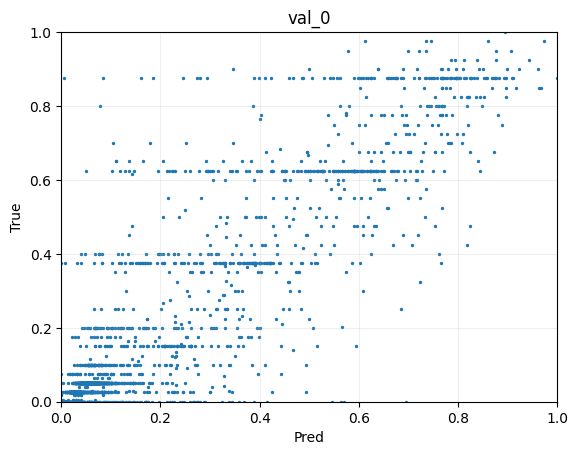

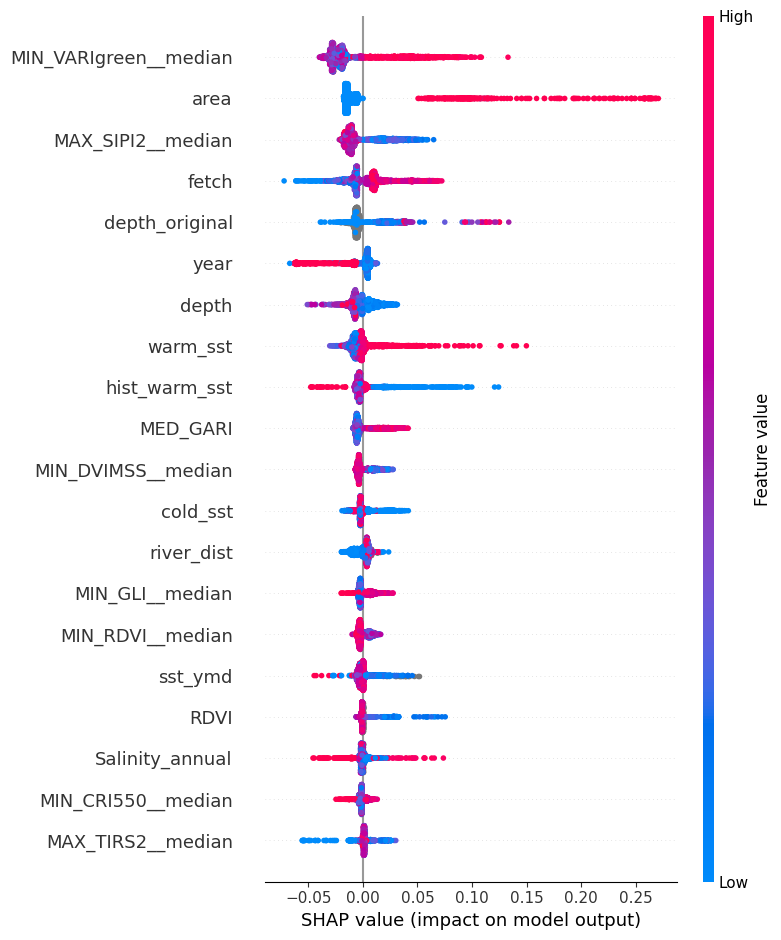

##############################
● CV1
##############################
Training until validation scores don't improve for 100 rounds
[500]	valid_0's fair: 0.00411848
[1000]	valid_0's fair: 0.00367566
[1500]	valid_0's fair: 0.00346381
[2000]	valid_0's fair: 0.00334577
[2500]	valid_0's fair: 0.00326153
[3000]	valid_0's fair: 0.00319706
[3500]	valid_0's fair: 0.00315478
[4000]	valid_0's fair: 0.00310991
[4500]	valid_0's fair: 0.00308087
[5000]	valid_0's fair: 0.00306502
[5500]	valid_0's fair: 0.00304661
[6000]	valid_0's fair: 0.00303272
[6500]	valid_0's fair: 0.00301564
[7000]	valid_0's fair: 0.0030026
[7500]	valid_0's fair: 0.00299283
[8000]	valid_0's fair: 0.00298276
[8500]	valid_0's fair: 0.00297299
[9000]	valid_0's fair: 0.00296425
Early stopping, best iteration is:
[9257]	valid_0's fair: 0.00296244
0.17854584419169373


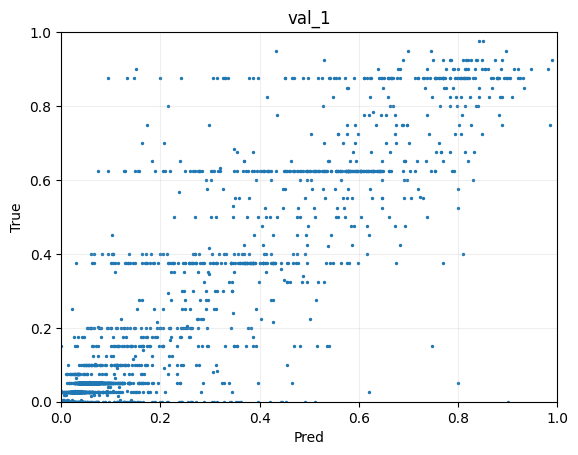

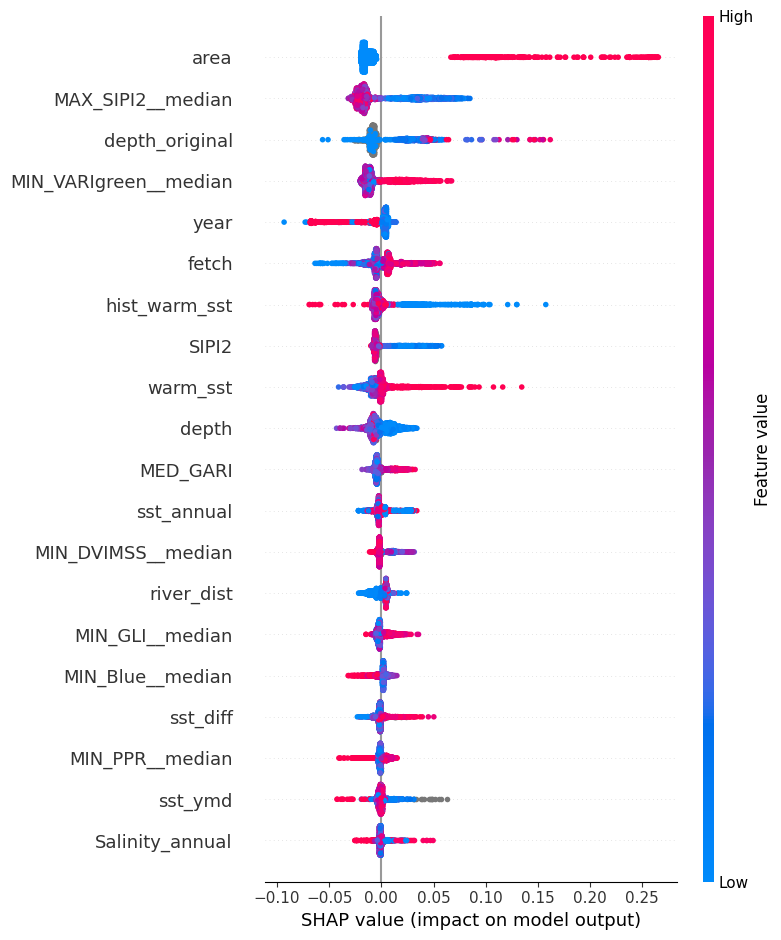

##############################
● CV2
##############################
Training until validation scores don't improve for 100 rounds
[500]	valid_0's fair: 0.00404265
[1000]	valid_0's fair: 0.00361863
[1500]	valid_0's fair: 0.00340468
[2000]	valid_0's fair: 0.00325692
[2500]	valid_0's fair: 0.0031695
[3000]	valid_0's fair: 0.00311185
[3500]	valid_0's fair: 0.0030777
[4000]	valid_0's fair: 0.00304255
[4500]	valid_0's fair: 0.00301259
[5000]	valid_0's fair: 0.00299439
[5500]	valid_0's fair: 0.00297499
[6000]	valid_0's fair: 0.00295988
[6500]	valid_0's fair: 0.00294977
[7000]	valid_0's fair: 0.00294375
[7500]	valid_0's fair: 0.00293704
[8000]	valid_0's fair: 0.00293359
[8500]	valid_0's fair: 0.00292512
Early stopping, best iteration is:
[8770]	valid_0's fair: 0.00292186
0.18108677376016635


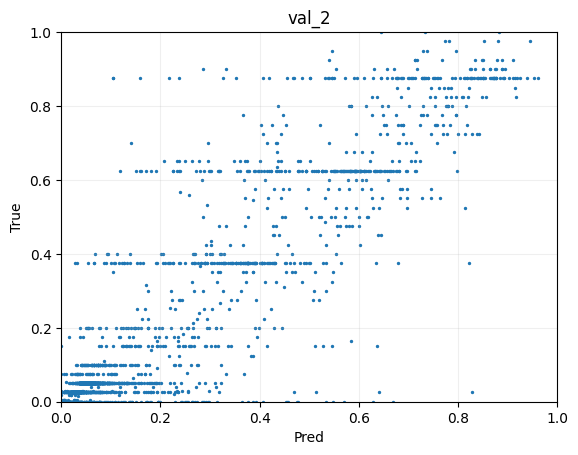

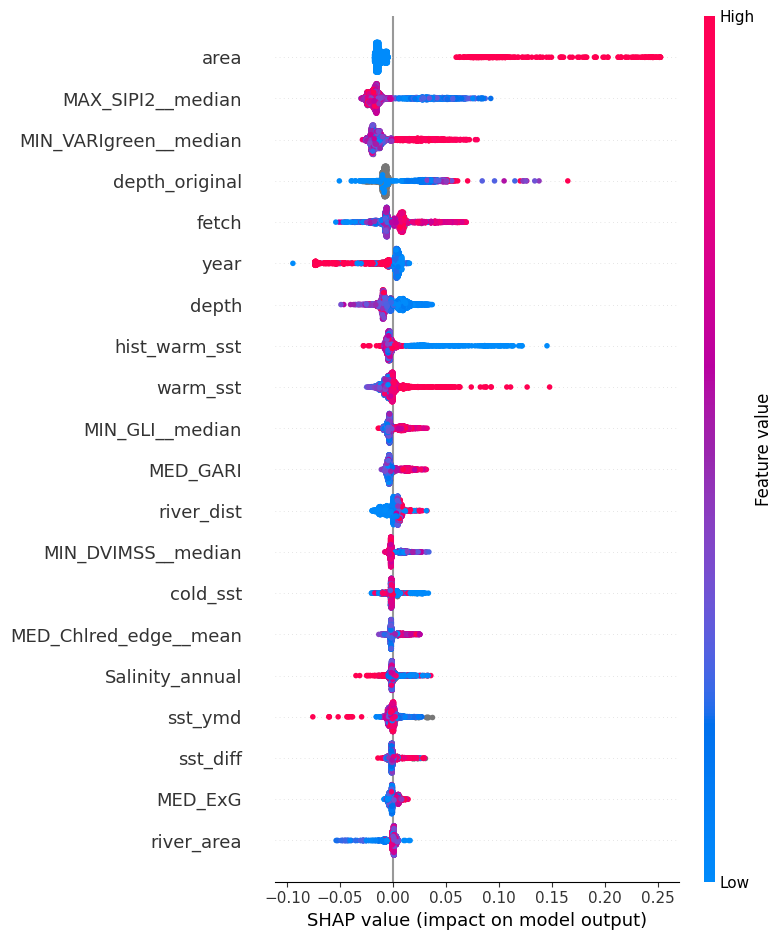

##############################
● CV3
##############################
Training until validation scores don't improve for 100 rounds
[500]	valid_0's fair: 0.00372849
[1000]	valid_0's fair: 0.00331152
[1500]	valid_0's fair: 0.00312055
[2000]	valid_0's fair: 0.00298036
[2500]	valid_0's fair: 0.00287627
[3000]	valid_0's fair: 0.00281426
[3500]	valid_0's fair: 0.00276647
[4000]	valid_0's fair: 0.00272327
[4500]	valid_0's fair: 0.00269434
[5000]	valid_0's fair: 0.00267162
[5500]	valid_0's fair: 0.00265407
[6000]	valid_0's fair: 0.00264261
[6500]	valid_0's fair: 0.00263033
[7000]	valid_0's fair: 0.00261955
[7500]	valid_0's fair: 0.00260988
[8000]	valid_0's fair: 0.00260004
[8500]	valid_0's fair: 0.00259509
Early stopping, best iteration is:
[8734]	valid_0's fair: 0.00259286
0.17760088120223325


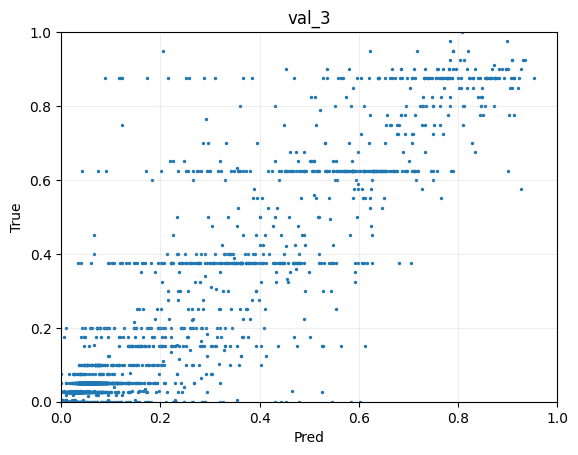

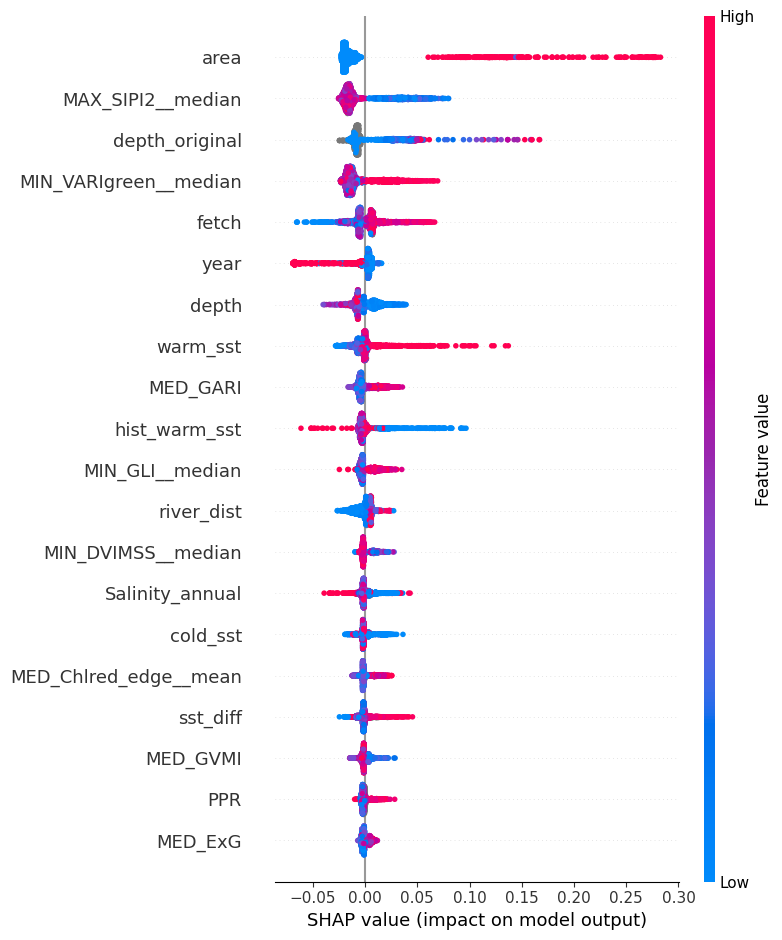

##############################
● CV4
##############################
Training until validation scores don't improve for 100 rounds
[500]	valid_0's fair: 0.00433365
[1000]	valid_0's fair: 0.00388968
[1500]	valid_0's fair: 0.00365951
[2000]	valid_0's fair: 0.00351132
[2500]	valid_0's fair: 0.00341359
[3000]	valid_0's fair: 0.00332788
[3500]	valid_0's fair: 0.00326791
[4000]	valid_0's fair: 0.00322712
[4500]	valid_0's fair: 0.00319589
[5000]	valid_0's fair: 0.00317216
[5500]	valid_0's fair: 0.00315012
[6000]	valid_0's fair: 0.00313469
[6500]	valid_0's fair: 0.00312178
[7000]	valid_0's fair: 0.00310656
[7500]	valid_0's fair: 0.0030908
[8000]	valid_0's fair: 0.00308263
[8500]	valid_0's fair: 0.00307532
[9000]	valid_0's fair: 0.00307042
[9500]	valid_0's fair: 0.00306497
[10000]	valid_0's fair: 0.00305712
[10500]	valid_0's fair: 0.00305304
[11000]	valid_0's fair: 0.00304843
[11500]	valid_0's fair: 0.00304346
[12000]	valid_0's fair: 0.00303919
[12500]	valid_0's fair: 0.00303461
[13000]	valid_0'

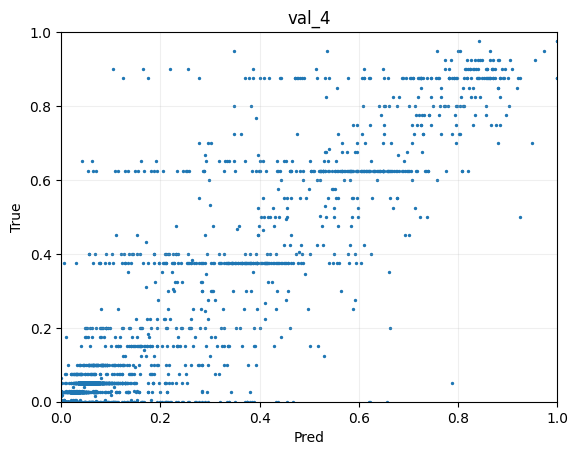

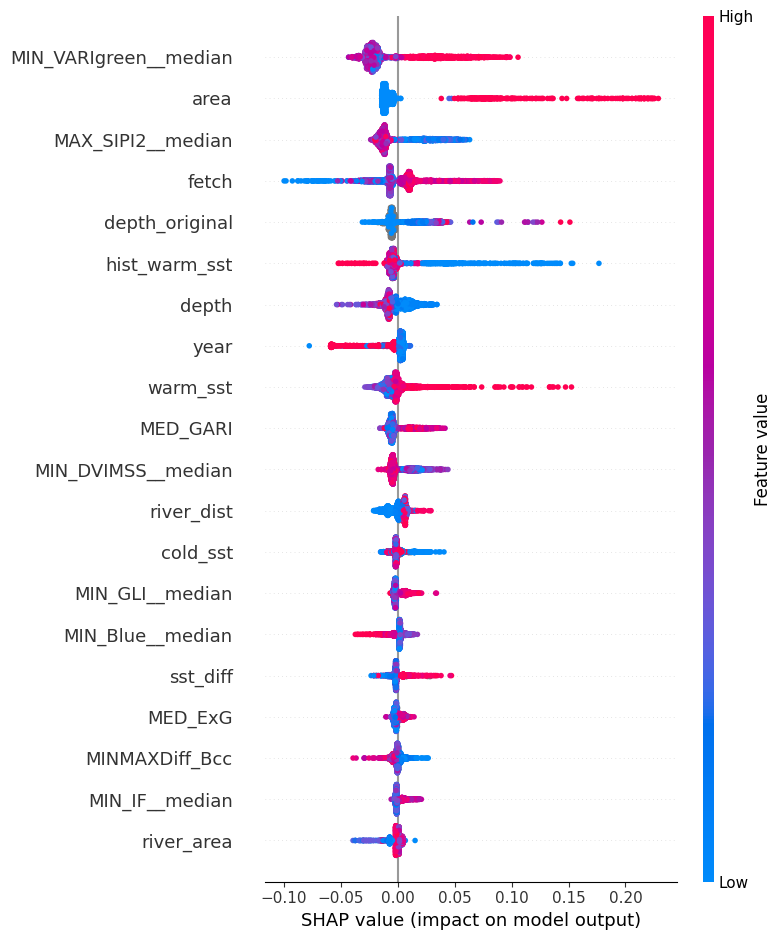

##############################
学習曲線
##############################


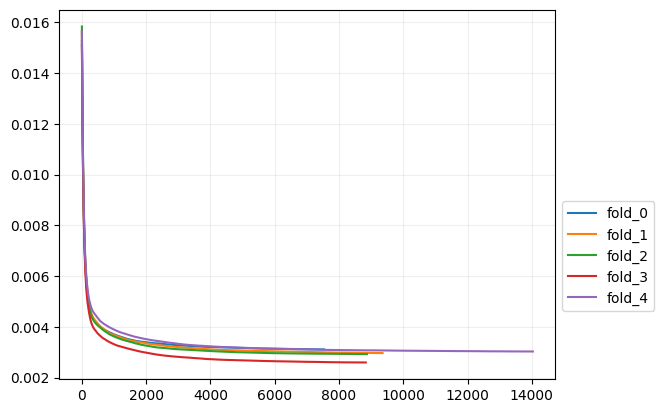

In [20]:
params = {
    'objective': 'fair',
    'metric': 'fair',
    'boosting_type': 'gbdt',
    'max_depth': 5,
    'n_estimators': 15000,
    'learning_rate': 0.01,
    # 'num_leaves': 50,
    # 'colsample_bytree': 0.6,
    # 'subsample': 0.5,
    'verbose': -1,
    'n_jobs': -1,
    'seed': 46,
}

results_rmse, fi_df, y_test_pred = my_cross_val_predict(train, test, y_name="log_cover", y_raw_name="cover", params=params, features=features)

CV0: 0.115
CV1: 0.114
CV2: 0.112
CV3: 0.106
CV4: 0.114
Average: 0.112


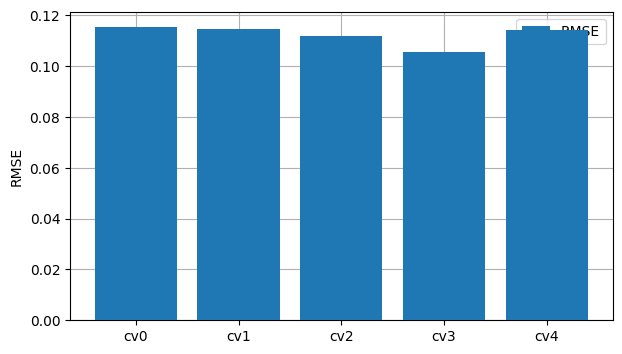

In [21]:
for i, rmse in enumerate(results_rmse):
    print(f"CV{i}: {rmse:.3f}")
print(f"Average: {np.average(results_rmse):.3f}")
plot_results(results_rmse)

(5, 391)


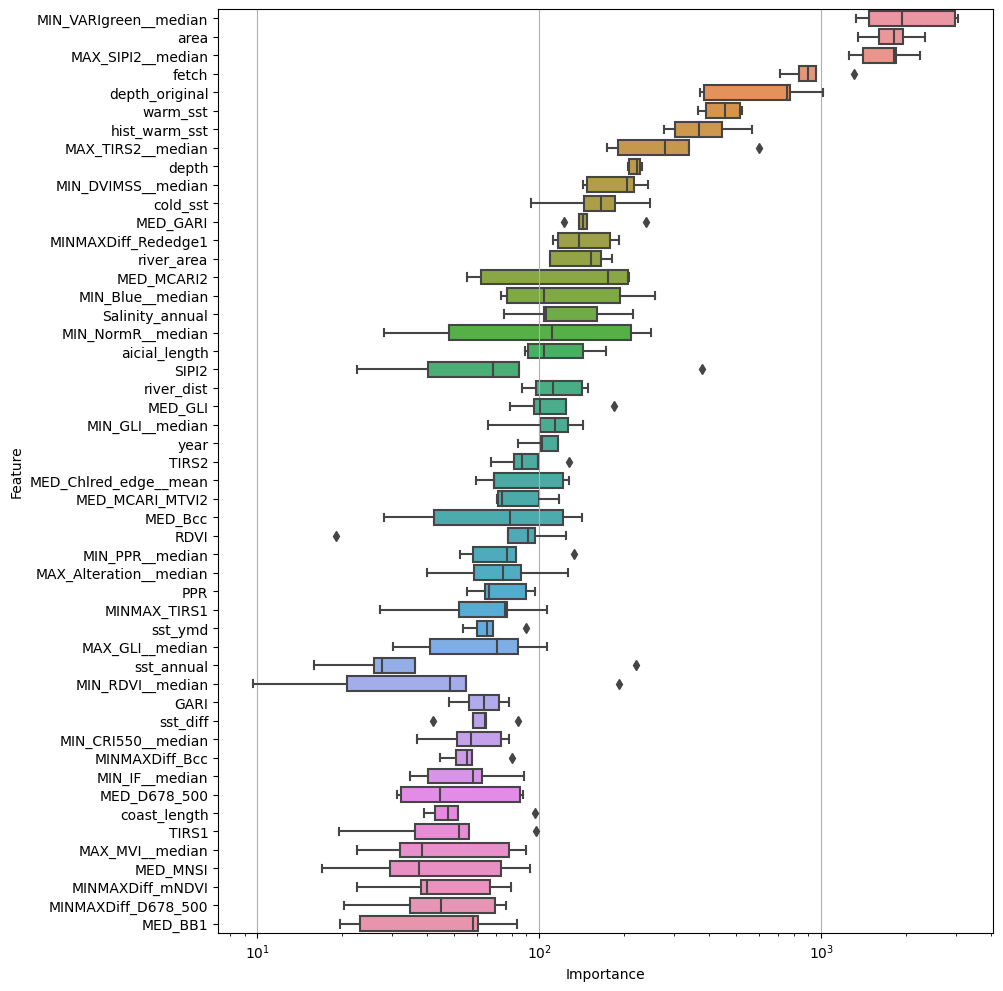

In [22]:
plot_importance(fi_df, figsize=(10, 12))

# Sub作成

In [23]:
test_sub = pd.DataFrame(y_test_pred, columns=["pred"])
test_sub

,pred
0,0.088574
1,0.073245
2,0.557456
3,0.044732
4,0.126633
...,...
4034,0.129205
4035,0.042611
4036,0.335374
4037,0.061785


In [24]:
test_pred_mean = test_sub["pred"].mean()
test_pred_mean

0.18097006053629303

In [25]:
test_sub2 = test_sub.copy()
public_mean = 0.09088
# test_sub["pred"] = test_sub["pred"] * (public_mean / test_pred_mean)
test_sub2["pred"] -= (test_pred_mean - public_mean)
test_sub2["pred"] = np.clip(test_sub2["pred"].values, 0, 1)
test_sub2

,pred
0,0.000000
1,0.000000
2,0.467366
3,0.000000
4,0.036543
...,...
4034,0.039115
4035,0.000000
4036,0.245284
4037,0.000000


In [26]:
print("pred_最小値:", test_sub["pred"].min())
print("pred_最大値:", test_sub["pred"].max())
print("pred_平均値:", test_sub["pred"].mean())

pred_最小値: 0.0
pred_最大値: 0.8822040492755959
pred_平均値: 0.18097006053629303


In [27]:
print("●後処理後")
print("pred_最小値:", test_sub2["pred"].min())
print("pred_最大値:", test_sub2["pred"].max())
print("pred_平均値:", test_sub2["pred"].mean())

●後処理後
pred_最小値: 0.0
pred_最大値: 0.7921139887393029
pred_平均値: 0.10759177958567581


In [28]:
if SAVE_SUB:
    test_sub.to_csv(SAVE_SUB_DIR / f"{SUB_FILE_NAME}.csv", header=False)
    test_sub2.to_csv(SAVE_SUB_DIR / f"{SUB_FILE_NAME}_mod.csv", header=False)

In [30]:
test[features].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4039 entries, 0 to 4038
Columns: 391 entries, coastal_dist to MAX_GARI__median
dtypes: float64(391)
memory usage: 12.0 MB


In [38]:
df_nullCount = pd.DataFrame(columns=["nullCount"])
for feat in features:
    df_nullCount.loc[feat, "nullCount"] = test[feat].isnull().sum()
df_nullCount.sort_values(by="nullCount", inplace=True, ascending=False)
df_nullCount.head(20)

,nullCount
depth_original,2053
NDWI,1128
MINMAX_DSWI_5,1128
MINMAX_NIR,1128
MINMAX_MCARI2,1128
MINMAX_NLI,1128
Chlgreen,1128
SLAVI,1128
MINMAX_Cigreen,1128
NLI,1128


In [48]:
df_nullCount.iloc[90:110]

,nullCount
MINMAX_SWIR1,1123
Alteration,1123
MINMAX_PPR,1123
MINMAX_Blue,1123
sunAzimuth,1123
Landsat_num,1123
IR550,1123
MINMAX_IR550,1123
SWIR1,1123
NBR2,1123


In [33]:
train[features].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14140 entries, 0 to 14139
Columns: 391 entries, coastal_dist to MAX_GARI__median
dtypes: float32(200), float64(191)
memory usage: 31.4 MB


In [35]:
df_nullCount_train = pd.DataFrame(columns=["nullCount_train"])
for feat in features:
    df_nullCount_train.loc[feat, "nullCount_train"] = train[feat].isnull().sum()
df_nullCount_train.sort_values(by="nullCount_train", inplace=True, ascending=False)
df_nullCount_train.head(30)

,nullCount_train
depth_original,9721
MINMAX_DSWI_5,3616
MINMAX_Cigreen,3616
RDVI,3616
NLI,3616
DSWI,3616
MINMAX_mCRIG,3616
MCARI2,3616
MINMAX_AVI,3616
Chlred_edge,3616
